Partial Least Squares - Discriminant Analysis (PLS-DA)
===

Author: Nathan A. Mahynski

Date: 2023/09/12

Description: Discussion and examples of different PLS-DA approaches.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/learn/plsda.ipynb)

[PLS](pls.ipynb) can also be applied to classification problems.  The general idea is to perform a PLS(2) decomposition
between $X$ and $\vec{y}$, where now $\vec{y}$ is one-hot encoded for the different classes.  For binary classification, a simple 0 or 1 is adequate.  The scores that come from the PLS decomposition are then used as an input to a
classification model.  So really, PLS-DA is just using PLS to find a good subspace, then performing classication
on the transformed coordinates in that space; this classification is the "discrimination" which can be done
by any number of methods.  The PLS outputs floating point numbers not integers, so a decision needs to be made
on how to "cluster" and assign points to a given class. Some common methods are:

1. Closest class centroid - obviously the Euclidean distance in PLS-DA score space (projection) is not necessarily a good representation of class differences so you need to validate this with test set, etc. See this [paper](https://link.springer.com/article/10.1007/s11306-007-0099-6) and more discussion in [Pomerantsev et al.](https://onlinelibrary.wiley.com/doi/abs/10.1002/cem.3030).

2. Thresholding (some cutoff distance).

3. Some statistical confidence bounds based on tolerable mis-classfication error rates.

4. Build logistic regression, or other decision boundary, etc. in score (projected) space - this is better than option (1) which avoids relying on distance being proportional to likelihood of a class.

This essentially just uses (supervised) PLS to find a good subspace to project into.  However, we could also use something like LDA instead (discussed in the previous section); for LDA we are bounded by $n_{\rm dimensions} <= {\rm min}\left(n_{\rm classes} - 1, n_{\rm features} \right)$, which we are not in PLS.  So if $n_{\rm classes}$ is low, LDA can only find a very low-D subspace; it may be better to find some space between that and $n_{\rm features}$, which PLS can provide.

PLS-DA is widely applied in cheminformatics research since we often have a $p > n$ instance which can be handled
automatically with PLS.  This is especially true of -omics fields.   However, nonlinear techniques such as [artificial neural networks can also be used](https://link.springer.com/article/10.1007/s11306-020-1640-0) have been shown to perform as well. A thorough review of the state of the art PLS-DA by Lee et al. is available [here](https://pubs.rsc.org/en/content/articlehtml/2018/an/c8an00599k)

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [1]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import scipy

import numpy as np

from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

from pychemauth.classifier.plsda import PLSDA
from pychemauth.preprocessing.scaling import CorrectedScaler

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy     : 1.24.3
sklearn   : 1.3.0
scipy     : 1.11.1
matplotlib: 3.7.2
watermark : 2.4.3
pychemauth: 0.0.0b4



Starting Out
---

["Multiclass partial least squares discriminant analysis: Taking the right way—A critical tutorial," by
Pomerantsev and Rodionova, Journal of Chemometrics, 32 (2018)](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/abs/10.1002/cem.3030) suggests 2 approaches to PLS-DA. These are "hard" and "soft" PLS-DA, which are distinguished by how they determine their discrimination boundaries.  Both begin in the same way.  First, let's consider a naive approach to PLS-DA.

1. One-hot encode (OHE) $Y$ for different classes.

> This means that classes form the vertices of $k$-dimensional simplex, where we have $k$ classes.  Following [Indahl et al.](https://onlinelibrary.wiley.com/doi/abs/10.1002/cem.1061), you could reduce the dummy matrix to remove a dimension;  if you have 4 classes, this forms a tetrahedron - i.e., represent classes as +1 for $k$-1 instances and for the last one indicate it as all zeros (Figure credit to Pomerantsev and Rodionova, see above).  
>
> Convert
>
> $$
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$
>
> to
>
>$$
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
0 & 0 & 0 \\
\end{bmatrix}
$$
>
> The first matrix defines a $k$-1 dimensional affine subspace (this logic is also why when [LDA functions as a dimensionality reduction tool](https://scikit-learn.org/stable/modules/lda_qda.html#mathematical-formulation-of-lda-dimensionality-reduction) it is bounded by $n_{\rm classes} - 1$). This is made more explicitly clear by the second matrix which clearly has rank $k-1$ and encloses a tetrahedral volume in 3D.

<img src="https://github.com/mahynski/pychemauth/blob/main/docs/_static/fig1_pomerantsev_2018.png?raw=1" style="width:500px;">

2. Center $X$ (and possibly scale, too), and mean-center $Y$.

3. Perform [PLS2 regression](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html) to obtain the predictions, $\hat{Y}$.

4. Compare $\hat{Y}$ to the OHE vectors and choose the closest one to assign a class.  

However, step 4 is tricky because of the fact that $\hat{Y}$ has rank $k$-1.  if you tried to compute a Euclidean distance ($k$-D space) between one vertex and a given prediction, it would be possible - but this would not really be correct since we really need to the distance in the ($k$-1)-D space. Moreover, if you tried to compute a Mahalanobis distance this would fail because the covariance matrix will be singular. If you just use Indahl's approach and do PLS2 with the second matrix, it seems you can proceed; however, Pomerantsev and Rodionova proposed that you instead use the normal OHE matrix (the first one above) and then perform PCA on the $\hat{Y}$ response.  The PCA will naturally only have $k-1$ non-zero eigenvalues, so you can simply use this to project the responses into that subspace.  You can then compute the distances in that subspace to perform classification.  These steps are as follows:

1. One-hot encode response vector, $Y_{\rm train}$.

2. Perform PLS2 to get prediction, $\hat{Y}_{\rm train}$, after appropriate centering/scaling.

3. Perform PCA on $\hat{Y}_{\rm train}$ - to do this, you must first center $\hat{Y}_{\rm train}$. Project into $k-1$ dimensional space to obtain the PCA loadings matrix $T$.

4. Classify points in $T$.

In summary, $(X, Y) \xrightarrow{\text{PLS2}} \hat{Y} \xrightarrow{\text{PCA}} T$.  This is essentially a composition of multiple subspace projection methods, but ultimately only the PCA scores ($T$) are used to do the classification.

This assumes that $k < n_{\rm features}$.  Since we are projecting into a $k$-D space and relying on a PCA transformation of that space this is a requirement.  Usually when PLS is being used this is the case.

Pomerantsev and Rodionova propose 2 different ways to perform step 4: a hard classification and a soft classification.

Hard PLS-DA
---

**Hard classification assigns an object to 1 and only 1 class.**  It is not generally valid to use this approach for authentication studies since this method will not be applicable in "open world" conditions where a classifer may encounter classes different from those trained on. Still, this conventional "closed world" classifier can still be powerful. See [Rodionova et al.](https://www.sciencedirect.com/science/article/pii/S0165993615302193) for more details.

Recall that [LDA](lda.ipynb) uses multivariate Gaussians to model class probabilities; this essentially assigns a point to the class by finding the smallest Mahalanobis distance to a known class center (while also accounting for the class prior probabilities).  We can use a similarly inspired approach here.

The pooled covariance matrix is known from PCA:

$$
cov(T^T) = \Lambda \sim T^TT
$$

It is a diagonal matrix because PCA found orthogonal components $\left( \Lambda = {\rm diag}\left( \lambda_1, \dots, \lambda_{k-1} \right) \right)$.  The class centers, $c_k$, are computed by column centering them (since this was done in the PCA step to projection $\hat{Y}$) then using the PCA eigenvectors to project to this $k-1$ dimensional space.

The distance from a projected point, $t_i$, to a class, $k$ is given by its Mahalanobis distance:

$$
d_{ik} = (t_i - c_k)\Lambda^{-1}(t_i - c_k)^{T}
$$

It is perfectly fine to use the Mahalanobis distance as classification metric, but it is not identical to the [LDA](lda.ipynb) decision function, strictly speaking.  You could also use other classifications approaches like trees, QDA, etc.

In [4]:
def hard_plsda(X_test, X_train, y_train, n_components=2):
    # 1. Preprocess data (one hot encoding, centering)
    ohencoder = OneHotEncoder(sparse_output=False) # Convert integers to OHE
    x_pls_scaler = CorrectedScaler(with_mean=True, with_std=True) # Center and (optionally) scale X
    y_pls_scaler = CorrectedScaler(with_mean=True, with_std=False) # Center do not scale Y

    y_train = y_pls_scaler.fit_transform(ohencoder.fit_transform(y_train.reshape(-1,1)))
    X_train = x_pls_scaler.fit_transform(X_train)

    X_test = x_pls_scaler.transform(X_test)

    # 2. PLS2 - predict y_hat
    plsda = PLSRegression(n_components=n_components,
                          max_iter=5000,
                          tol=1.0e-9,
                          scale=False) # Already scaled, centered as needed
    _ = plsda.fit(X_train, y_train)

    # Y was centered for PLS fitting, so de-center to return to "normal"
    y_hat_train = y_pls_scaler.inverse_transform(plsda.predict(X_train))
    y_hat_test = y_pls_scaler.inverse_transform(plsda.predict(X_test))

    # 3. Perform PCA on y_hat_train - use k-1 dimensions
    # Note that sklearn's PCA automatically centers the input so we do not need to do it explicitly
    pca = PCA(n_components=len(ohencoder.categories_[0])-1, random_state=0)
    T_train = pca.fit_transform(y_hat_train) # The means of y_hat_train are stored
    T_test = pca.transform(y_hat_test) # The means are re-used here to center
    class_centers = pca.transform(np.eye(len(ohencoder.categories_[0]))) # Centers based on y_hat_train automatically

    # As a sanity check, proof that covariance of T is diagonal matrix made of eigenvalues from PCA transform
    L = np.cov(T_train.T)
    assert(np.allclose(np.cov(T_train.T), np.eye(len(pca.explained_variance_))*pca.explained_variance_))

    # 4. Compute Mahalanobis distance (squared) and classify based on the smallest distance (squared)
    d2 = []
    for t in T_test:
        d2.append([
            np.matmul(
                np.matmul(
                    (t - class_centers[i]),
                    np.linalg.inv(L)),
                (t - class_centers[i]).reshape(-1,1)
            )[0] for i in range(len(class_centers))
        ])
    d2 = np.array(d2)

    prediction = np.array([ohencoder.categories_[0][c] for c in np.argmin(d2, axis=1)] )

    return prediction, d2, T_train, T_test

In [5]:
X, Y = sklearn.datasets.make_blobs(
    n_samples=100,
    n_features=5,
    centers=3,
    cluster_std=3,
    shuffle=True,
    random_state=0
)

X_train, y_train = X[:80], Y[:80]
X_test, y_test = X[80:], Y[80:]

prediction, squared_distances, T_train, T_test = hard_plsda(X_test, X_train, y_train, n_components=2)

In [6]:
# In this case, the PLS-DA predicts the target classes perfectly on the test set.
print('Actual\tPrediction\tEqual?\n------------------------------')
for act, pred in zip(y_test, prediction):
    print(act, '\t', pred, '\t\t', pred==act)

Actual	Prediction	Equal?
------------------------------
0 	 0 		 True
0 	 0 		 True
1 	 1 		 True
0 	 0 		 True
0 	 0 		 True
0 	 0 		 True
1 	 1 		 True
1 	 1 		 True
2 	 2 		 True
2 	 2 		 True
0 	 0 		 True
1 	 1 		 True
0 	 0 		 True
2 	 2 		 True
0 	 0 		 True
0 	 0 		 True
2 	 2 		 True
1 	 1 		 True
2 	 2 		 True
2 	 2 		 True


In [7]:
# The same calculation can be accomplished with pychemauth
plsda = PLSDA(n_components=2, style='hard', scale_x=True)
_ = plsda.fit(X_train, y_train)

In [8]:
assert np.all(plsda.predict(X_test) == prediction)
assert np.allclose(plsda.transform(X_train), T_train)
assert np.allclose(plsda.transform(X_test), T_test)
assert np.allclose(plsda.mahalanobis(X_test), squared_distances)

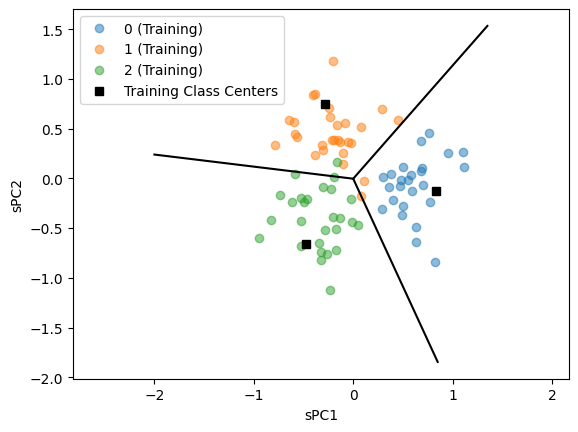

In [9]:
_ = plsda.visualize(styles=['hard'])

<h3>Figures of Merit</h3>

Figures of merit for authentication models need to reflect their performance not only on known classes, but also on future uknowns.  A summary of commonly employed metrics is available [here](https://www.sciencedirect.com/science/article/pii/S0165993612000684).

In [10]:
fom = plsda.figures_of_merit(plsda.predict(X_train), y_train)

In [11]:
# Essentially this is a confusion matrix (true labels are rows, columns are predicted labels).
# For Hard PLS-DA, the rows sum up to the number of examples of each class since each is assigned to only one column,
# and nothing is assigned to the unknown class (-1).
fom['CM']

,0,1,2,-1
0,25,0,0,0
1,2,26,0,0
2,0,1,26,0


In [12]:
# Total samples of each class.
fom['I']

0    25
1    28
2    27
dtype: int64

In [13]:
# Class sensitivity is the fraction of each class that was assigned to that class (like an accuracy) = true positive rate.
fom['CSNS']

0    1.000000
1    0.928571
2    0.962963
dtype: float64

In [14]:
# Class specificity is the fraction of alternate classes correctly NOT assigned to a class = 1 - false positive rate,
# or the true negative rate.
fom['CSPS']

0    0.963636
1    0.980769
2    1.000000
dtype: float64

In [15]:
# For example 2 examples of class 1 were assigned to class 0.
total_non_class_0 = fom['I'][1] + fom['I'][2]
assigned_to_class_0 = 2

1.0 - assigned_to_class_0 / total_non_class_0

0.9636363636363636

In [16]:
# CEFF is the geometric mean of the CSPS and CSNS.
fom['CEFF']

0    0.981650
1    0.954314
2    0.981307
dtype: float64

In [17]:
# Total sensitivity reflects the number of correct assignments (the diagonal of df).
fom['TSNS']

0.9625

In [18]:
(fom['CM'][0][0] + fom['CM'][1][1] + fom['CM'][2][2]) / fom['I'].sum()

0.9625

In [19]:
# Total specificity reflects the total number of incorrect assignments (the off-diagonals of df).
# Note - this is calculated differently for HARD vs. SOFT PLS-DA, which will be discussed in the next section.
fom['TSPS']

0.9625

In [20]:
1.0 - (fom['CM'][[0,1,2]].sum().sum() - (fom['CM'][0][0] + fom['CM'][1][1] + fom['CM'][2][2])) / fom['I'].sum()

0.9625

In [21]:
# Again, TEFF is the geometric mean of TSPS and TSNS.
fom['TEFF']

0.9625

In [22]:
# For Hard PLS-DA ONLY, we have TEFF = TSNS = TSPS = Accuracy.
accuracy = np.sum(plsda.predict(X_train) == y_train) / len(y_train)
fom['TEFF'], fom['TSNS'], fom['TSPS'], accuracy

(0.9625, 0.9625, 0.9625, 0.9625)

Soft PLS-DA
---

Rather than using an LDA-like distance (which assumes all classes have the same covariance matrix), you can instead use a QDA-like distance which uses a separate within-class covariance matrix for each class.  Each within-class covariance matrix is given by:

$$
S_k = \frac{1}{I_k} \sum_{i \in \omega(k)} (t_i-c_k)^T(t_i-c_k)
$$

where there are $I_k$ samples from class $k$ and $\omega(k)$ denotes which data points (in the training set) belong to class $k$.  Recall that class centers, $c_k$, originate from a fixed "corner" of the polytope (tetrahedron in the above example) resulting from one-hot encoding;  thus, they are known and we do not need to substract 1 degree of freedom from the estimation of the class center ($I_k - 1$).  The Mahalanobis distance (squared) as:

$$
d_{ik} = (t_i - c_k)S_k^{-1}(t_i - c_k)^{T}
$$

Assuming the distances follow a chi-squared distribution we can establish a critical distance below which we assume point i belongs to class $k$, and beyond which we assume it does not.

$$
d_{\rm crit} = \chi^{-2}(1-\alpha, k-1)
$$

where $\chi^{-2}$ is the quantile of the chi-squared distribution with $k$-1 degrees of freedom and a type I error rate of $\alpha$. $H_0$ is that a point belongs to class $k$; type I error is the rejection of a true $H_0$ (that it belongs to class $k$) so this represents the rate at which we reject that a point belongs to a class that it truly does belong to.  

One can also specify an outlier threshold (which will be different for each class, unlike $d_{\rm crit}$:

$$
d_{\rm out} = \chi^{-2}((1-\gamma)^{1/I_k}, k-1)
$$

We expect the $\chi^2$ [distribution](https://en.wikipedia.org/wiki/Chi-square_distribution) since it represents the sum of squres of random variates; here, each direction is assumed to be a random variable and thus, computing a Mahalanobis distance (in a $k$-1 dimensional space) as done above results in a sum of squares.

**Thus, Soft PLS-DA may assign a point to 1 or more classes, or to none at all.  This means it can be used for authentication studies.**

In [23]:
def soft_plsda(X_test, X_train, y_train, alpha=0.05, gamma=0.05, n_components=2):

    # *** This block is the same as Hard PLS-DA *** #

    # 1. Preprocess data (one hot encoding, centering)
    ohencoder = OneHotEncoder(sparse_output=False) # Convert integers to OHE
    x_pls_scaler = CorrectedScaler(with_mean=True, with_std=True) # Center and scale X
    y_pls_scaler = CorrectedScaler(with_mean=True, with_std=False) # Center do not scale Y

    ohencoder.fit(y_train.reshape(-1,1))
    class_mask = {}
    for i in range(len(ohencoder.categories_[0])):
        class_mask[i] = y_train == ohencoder.categories_[0][i]

    y_train = y_pls_scaler.fit_transform(ohencoder.transform(y_train.reshape(-1,1)))
    X_train = x_pls_scaler.fit_transform(X_train)

    X_test = x_pls_scaler.transform(X_test)

    # 2. PLS2 - predict y_hat
    plsda = PLSRegression(n_components=n_components,
                          max_iter=5000,
                          tol=1.0e-9,
                          scale=False) # Already scaled, centered as needed
    _ = plsda.fit(X_train, y_train)

    # Y was centered for PLS fitting, so de-center to return to "normal"
    y_hat_train = y_pls_scaler.inverse_transform(plsda.predict(X_train))
    y_hat_test = y_pls_scaler.inverse_transform(plsda.predict(X_test))

    # 3. Perform PCA on y_hat_train - use k-1 dimensions
    # Note that sklearn's PCA automatically centers the input so we do not need to do it explicitly
    pca = PCA(n_components=len(ohencoder.categories_[0])-1, random_state=0)
    T_train = pca.fit_transform(y_hat_train) # The means of y_hat_train are stored
    T_test = pca.transform(y_hat_test) # The means are re-used here to center
    class_centers = pca.transform(np.eye(len(ohencoder.categories_[0]))) # Centers based on y_hat_train automatically

    # ********************************************* #

    # Soft PLS-DA computes distances differently

    # 4. Compute within-class scatter from training set
    S = {}
    for i in range(len(ohencoder.categories_[0])):
        S[i] = np.zeros((T_train.shape[1], T_train.shape[1]), dtype=np.float64)
        for t in T_train[class_mask[i]]:
            # Same as an outer product
            S[i] += (t - class_centers[i]).reshape(-1,1).dot((t - class_centers[i]).reshape(-1,1).T)
        S[i] /= np.sum(class_mask[i])

    # 5. Compute Mahalanobis distance (squared) and classify based on the critical distance (squared)
    d2_crit = scipy.stats.chi2.ppf(1.0-alpha, len(ohencoder.categories_[0])-1)
    d2_out = [scipy.stats.chi2.ppf((1.0-gamma)**(1.0/np.sum(class_mask[i])), len(ohencoder.categories_[0])-1)
             for i in range(len(ohencoder.categories_[0]))
            ] # Outlier cutoff - these can only be checked for the training set

    d2 = []
    for t in T_test:
        d2.append([
            np.matmul(
                np.matmul(
                    (t - class_centers[i]),
                    np.linalg.inv(S[i])),
                (t - class_centers[i]).reshape(-1,1))[0]
            for i in range(len(ohencoder.categories_[0]))
        ])
    assert(np.all(np.array(d2)>=0)), 'All Mahalanobis distances must be >= 0'

    # Return all classes within d_crit, sorted from smallest to largest. "NOT_ASSIGNED" means no assignment.
    predictions = []
    for row in d2:
        # The lower distance (squared), the higher the certainty of that class
        d2_sorted = sorted(zip(ohencoder.categories_[0], row), key=lambda x:x[1])
        belongs_to = [x[0] for x in d2_sorted if x[1] < d2_crit]
        if len(belongs_to) == 0:
            belongs_to = ["NOT_ASSIGNED"]
        predictions.append(belongs_to)

    # Check for outliers in the training data - in principle, you should remove these and retrain.
    outliers = [False]*X_train.shape[0]
    for j, t in enumerate(T_train):
        # Find which class entry j belongs to
        cat = None
        for i in range(len(ohencoder.categories_[0])):
            if class_mask[i][j]:
                cat = i
                break
        d2_ = np.matmul(np.matmul((t - class_centers[cat]), np.linalg.inv(S[cat])), (t - class_centers[cat]).reshape(-1,1))[0]
        if d2_ > d2_out[i]:
            outliers[j] = True

    return predictions, outliers, d2

In [24]:
prediction, outliers, squared_distances = soft_plsda(X_test, X_train, y_train, alpha=0.05, gamma=0.05, n_components=2)

In [25]:
# In this case, the data is well-behaved
np.any(outliers)

False

In [26]:
# Here we see that each row can actually have muliple assignments!  We have sorted them in order of lowest distance.
# In this case, even when multiple assignments are made, the lowest distance (first prediction) is equal to its
# true class, which is good.
print('Actual\tPrediction\tEqual?\n--------------------------------')
for act, pred in zip(y_test, prediction):
    print(act, '\t', pred, '\t'*(2-len(pred) + 1), (pred==act if len(pred) == 1 else [False])[0])

Actual	Prediction	Equal?
--------------------------------
0 	 [0] 		 True
0 	 [0] 		 True
1 	 [1] 		 True
0 	 [0] 		 True
0 	 [0] 		 True
0 	 [0] 		 True
1 	 [1, 2] 	 False
1 	 [1] 		 True
2 	 [2] 		 True
2 	 [2] 		 True
0 	 [0, 1] 	 False
1 	 [1] 		 True
0 	 [0] 		 True
2 	 [2] 		 True
0 	 [0] 		 True
0 	 [0] 		 True
2 	 [2] 		 True
1 	 [1] 		 True
2 	 [2] 		 True
2 	 [2] 		 True


In [27]:
# The same calculation can be accomplished with pychemauth
plsda = PLSDA(n_components=2, style='soft', scale_x=True)
_ = plsda.fit(X_train, y_train)

In [28]:
assert np.all(plsda.predict(X_test) == prediction)
assert np.allclose(plsda.mahalanobis(X_test), squared_distances)

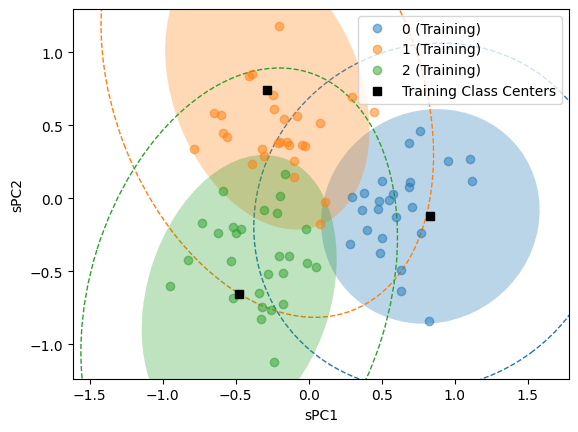

In [29]:
# You can see the overlapping ellipses for the training set where multiple assignments would be made
_ = plsda.visualize(styles=['soft'])

<h3>Figures of Merit</h3>

In [30]:
fom = plsda.figures_of_merit(plsda.predict(X_train), y_train)

In [31]:
# Now we see that some instances are assigned to the -1 column (unknown)
fom['CM']

,0,1,2,-1
0,25,1,0,0
1,1,27,5,1
2,0,6,27,0


In [32]:
# Note how the sums of the rows do not equal the total number of observations any more - this is because it is possible
# to assign a point to multiple classes now.
fom['I']

0    25
1    28
2    27
dtype: int64

In [33]:
# Class sensitivity is calculated in the same way - even though multiple assignments are possible. It is the diagonal
# terms over the total points from a class.
fom['CSNS']

0    1.000000
1    0.964286
2    1.000000
dtype: float64

In [34]:
fom['CSPS']

0    0.981818
1    0.865385
2    0.905660
dtype: float64

Specificity can pose a problem in Soft PLS-DA.  Suppose we have a very bad classifier which assigns every point to every class.  The matrix above (`fom['CM']`) would look like this:

|     | 0   | 1   | 2   | -1  |
| --- | --- | --- | --- | --- |
| 0   | 25  | 25  | 25  | 0   |
| 1   | 28  | 28  | 28  | 0   |
| 2   | 27  | 27  | 27  | 0   |

In this limit, the CSNS = 1 for all classes, because each point was assigned to its true class; however, it was also assigned to every other class, too.  CSPS = 0 for all classes then. Both CSPS and CSNS are bounded by [0, 1].  The same is not true for TSPS.

$$TSPS_{\rm hard} = 1 - \frac{\sum_{l \neq k} n_{kl}}{\sum I}$$

Here the numerator (sum of off-diagonals) is, in general, $\sum_{l \neq k} n_{kl} = (k-1) \sum I$, for $k$ total classes. Thus, $TSPS_{\rm hard} = 1 - (k-1) = 2 - k$; if $k > 2$ this can be negative, which is not sensible. One way to circuvent this is to scale the numerator by $(k-1)$ so the TSPS is bounded by [0, 1].

$$TSPS_{\rm soft} = 1 - \frac{1}{k-1} \frac{\sum_{l \neq k} n_{kl}}{\sum I}$$

This solves the problem, however, it is important to note that this affects TEFF.  Moreover, if we are comparing the performance of hard and soft models using TEFF we are no longer comparing "apple to apples" - most classifiers are much better than this "worst case scenario" so this rescaling tends to inflate TSPS (and thus TEFF) relative to hard models.  Furthermore, if you are comparing Soft PLS-DA to models like SIMCA, which also use TEFF, it is important to **remember their equations are different!**

In [35]:
fom['TSPS']

0.91875

In [36]:
1.0 - (fom['CM'][[0,1,2]].sum().sum() - (fom['CM'][0][0] + fom['CM'][1][1] + fom['CM'][2][2])) / fom['I'].sum() / (3-1)

0.91875

In [37]:
# TSNS is still computed in the same way
fom['TSNS']

0.9875

In [38]:
(fom['CM'][0][0] + fom['CM'][1][1] + fom['CM'][2][2]) / fom['I'].sum()

0.9875

In [39]:
# TEFF is the geometric mean of TSNS and TSPS
fom['TEFF']

0.9525049212471293